## Adding the Dolfinx library to the colab environment

In [ ]:
!wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"

## Importing the required libraries

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
from dolfinx import cpp as _cpp
from dolfinx import default_real_type
import basix
import dolfinx.fem.petsc
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
import time
import os

## Setting material properties and geometry dimensions

In [ ]:
# Material properties
E, nu = ScalarType(80000), ScalarType(0.22)	                                      #Young's modulus and Poisson's ratio
mu, lmbda, kappa = E/(2*(1 + nu)), E*nu/((1 + nu)*(1 - 2*nu)), E/(3*(1 - 2*nu))
Gc= ScalarType(0.009)	                                                            #Critical energy release rate
sts, scs= ScalarType(60), ScalarType(1000)	                                      #Tensile strength and compressive strength
shs = (2/3)*sts*scs/(scs-sts)
Wts = sts**2/(2*E)
Whs = shs**2/(2*kappa)


#Irwin characteristic length
lch=3*Gc*E/8/(sts**2)
#The regularization length
eps=0.08                                                                          #epsilon should not be chosen to be too large compared to lch. Typically eps<4*lch should work

h=eps/5



delta = (1+3*h/(8*eps))**(-2) * ((sts + (1+2*np.sqrt(3))*shs)/((8+3*np.sqrt(3))*shs)) * 3*Gc/(16*Wts*eps) + (1+3*h/(8*eps))**(-1) * (2/5)
comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank
log.set_log_level(log.LogLevel.ERROR)

#Geometry of the specimen
W, L = 25.0, 12.5                                                                 #making use of symmetry

## Generating the mesh with element size $h=\frac{ϵ}{5}$
(note that the mesh is saved in xdmf format)

In [ ]:
domain = mesh.create_rectangle(comm = comm,points=
                             [np.array([0,0]), np.array([W,-L])],n=[int(W/(32*h))
                             ,int(L/(32*h))], cell_type=mesh.CellType.triangle
                               , diagonal= mesh.DiagonalType.crossed)


def cell_criterion(x):
    """Given mesh coordinates, return if each point
    satisfies (x[1]>-4) & (x[0]<8)

    :param x: Input coordinates, shape (num_points, 3)
    :returns: Boolean array of shape (num_points, )
    """
    return (x[1]>-4) & (x[0]<8)

ir=0
while ir<2:
    domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
    cells_local = np.arange(domain.topology.index_map(
        domain.topology.dim).size_local, dtype=np.int32)
    midpoints = dolfinx.mesh.compute_midpoints(
        domain, domain.topology.dim, cells_local).T
    should_refine = np.flatnonzero(cell_criterion(midpoints)).astype(np.int32)
    domain.topology.create_entities(1)
    local_edges = dolfinx.mesh.compute_incident_entities(
        domain.topology, should_refine, domain.topology.dim, 1)
    domain = dolfinx.mesh.refine(domain, local_edges)
    ir+=1


def cell_criterion2(x):
    """Given mesh coordinates, return if each point
    satisfies (x[1]>-3) & (x[0]<9) & (x[0]>3)

    :param x: Input coordinates, shape (num_points, 3)
    :returns: Boolean array of shape (num_points, )
    """
    return (x[1]>-3) & (x[0]<9) & (x[0]>3)

ir=0
while ir<3:
    domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
    cells_local = np.arange(domain.topology.index_map(
        domain.topology.dim).size_local, dtype=np.int32)
    midpoints = dolfinx.mesh.compute_midpoints(
        domain, domain.topology.dim, cells_local).T
    should_refine = np.flatnonzero(cell_criterion2(midpoints)).astype(np.int32)
    domain.topology.create_entities(1)
    local_edges = dolfinx.mesh.compute_incident_entities(
        domain.topology, should_refine, domain.topology.dim, 1)
    domain = dolfinx.mesh.refine(domain, local_edges)
    ir+=1


with dolfinx.io.XDMFFile(domain.comm, "refined_mesh.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)

## Defining the function spaces

In [ ]:
# Defining the function spaces
V = fem.functionspace(domain, ("CG", 1, (domain.geometry.dim,)))                  #Function space for u
Y = fem.functionspace(domain, ("CG", 1))                                          #Function space for z

## Setting the Dirichlet part of boundary conditions

In [ ]:
maxdisp = -0.05

def left(x):
    return np.isclose(x[0], 0)

def front(x):
    return np.isclose(x[0], W)

def top(x):
    return np.isclose(x[1], 0)

def bottom(x):
    return np.isclose(x[1], -L)

def loadset(x):
    return (x[0]>0-1e-4) & (x[0]<1.0+1e-4) & (abs(x[1]-0)<1e-4)

def outer(x):
    return (x[1] < -L/10)

fdim = domain.topology.dim -1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
front_facets = mesh.locate_entities_boundary(domain, fdim, front)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)
bottom_facets = mesh.locate_entities(domain, fdim, bottom)
loadset_facets = mesh.locate_entities(domain, fdim, loadset)
outer_facets = mesh.locate_entities(domain, fdim, outer)


dofs_left = fem.locate_dofs_topological(V.sub(0), fdim, left_facets)
dofs_bottom = fem.locate_dofs_topological(V.sub(1), fdim, bottom_facets)
dofs_loadset = fem.locate_dofs_topological(V.sub(1), fdim, loadset_facets)

dofs_outer = fem.locate_dofs_topological(Y, fdim, outer_facets)

bcl = fem.dirichletbc(ScalarType(0), dofs_left, V.sub(0))
bcb = fem.dirichletbc(ScalarType(0), dofs_bottom, V.sub(1))
bct = fem.dirichletbc(ScalarType(0), dofs_loadset, V.sub(1))   # at the end, we have to change the value in the loop using bct.g.value[...] = ScalarType(t*maxdisp)
bcs = [bcl, bcb, bct]


bct_z = fem.dirichletbc(ScalarType(1), dofs_outer, Y)
bcs_z = [bct_z]


## Marking the facets and defining trial and test functions

In [ ]:
marked_facets = np.hstack([top_facets, bottom_facets, left_facets])
marked_values = np.hstack([np.full_like(top_facets, 1),
                           np.full_like(bottom_facets, 2),
                           np.full_like(left_facets, 3)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, domain.topology.dim -1,
                          marked_facets[sorted_facets],
                          marked_values[sorted_facets])

metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', domain=domain,
                 subdomain_data=facet_tag, metadata=metadata)
dS = ufl.Measure("dS", domain=domain, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)

# Define functions
du = ufl.TrialFunction(V)                                                         # Incremental displacement
v  = ufl.TestFunction(V)                                                          # Test function for u
u  = fem.Function(V, name="displacement")                                         # Displacement from previous iteration
u_inc = fem.Function(V)
dz = ufl.TrialFunction(Y)                                                         # Incremental phase field
y  = ufl.TestFunction(Y)                                                          # Test function for z
z  = fem.Function(Y, name="phasefield")                                           # Phase field from previous iteration
z_inc = fem.Function(Y)
d = len(u)

## Setting the initial conditions

In [ ]:
u.x.array[:] = 0.
fem.petsc.set_bc(u.vector, bcs)


z.x.array[:] = 1.
fem.petsc.set_bc(z.vector, bcs_z)


u_prev = fem.Function(V)
u_prev.x.array[:] = u.x.array
z_prev = fem.Function(Y)
z_prev.x.array[:] = z.x.array


y_dofs_top = fem.locate_dofs_topological(V.sub(1), fdim, top_facets)

## Defining a function to evaluate any field in parallel for visualization purposes

In [ ]:
def adjust_array_shape(input_array):
    if input_array.shape == (2,):                                                 # Check if the shape is (2,)
        adjusted_array = np.append(input_array, 0.0)                              # Append 0.0 to the array
        return adjusted_array
    else:
        return input_array
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

def evaluate_function(u, x):
    """[summary]
        Helps evaluated a function at a point `x` in parallel
    Args:
        u ([dolfin.Function]): [function to be evaluated]
        x ([Union(tuple, list, numpy.ndarray)]): [point at which to evaluate function `u`]

    Returns:
        [numpy.ndarray]: [function evaluated at point `x`]
    """


    if isinstance(x, np.ndarray):
        # If x is already a NumPy array
        points0 = x
    elif isinstance(x, (tuple, list)):
        # If x is a tuple or list, convert it to a NumPy array
        points0 = np.array(x)
    else:
        # Handle the case if x is of an unsupported type
        points0 = None

    points = adjust_array_shape(points0)

    u_value = []

    cells = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, points)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points)

    if len(colliding_cells.links(0)) > 0:
        u_value = u.eval(points, colliding_cells.links(0)[0])
        u_value = domain.comm.gather(u_value, root=0)
    return u_value[0]

## Defining stored energy, strain and, stress functions

In [ ]:
# Stored energy, strain and stress functions in linear isotropic elasticity (plane strain)

def energy(v):
    return mu*(ufl.inner(ufl.sym(ufl.grad(v)),ufl.sym(ufl.grad(v)))) + 0.5*(lmbda)*(ufl.tr(ufl.sym(ufl.grad(v))))**2

def epsilon(v):
    return ufl.sym(ufl.grad(v))

def sigma(v):
    return 2.0*mu*ufl.sym(ufl.grad(v)) + (lmbda)*ufl.tr(ufl.sym(ufl.grad(v)))*ufl.Identity(len(v))


def sigmavm(sig,v):
    return ufl.sqrt(1/2*(ufl.inner(sig-1/3*(1+nu)*ufl.tr(sig)*ufl.Identity(len(v)), sig-1/3*(1+nu)*ufl.tr(sig)*ufl.Identity(len(v))) + ((2*nu/3-1/3)**2)*ufl.tr(sig)**2 ))

eta = 0.0
# Stored energy density
psi1 = (z**2+eta)*(energy(u))
psi11 = energy(u)
# Total potential energy
Pi = psi1*dx
# Compute first variation of Pi (directional derivative about u in the direction of v)
R = ufl.derivative(Pi, u, v)
# Compute Jacobian of R
Jac = ufl.derivative(R, u, du)

## Defining the external force $c_{e}$ in the phase-field equation

In [ ]:
I1 = (z**2)*(1+nu)*ufl.tr(sigma(u))
SQJ2 = (z**2)*sigmavm(sigma(u),u)

alpha1 = (delta*Gc)/(shs*8*eps) - (2*Whs)/(3*shs)
alpha2 = (3**0.5*(3*shs - sts)*delta*Gc)/(shs*sts*8*eps) + (2*Whs)/(3**0.5*shs) - (2*3**0.5*Wts)/(sts)

ce = alpha2*SQJ2 + alpha1*I1 - z*(1-ufl.sqrt(I1**2)/I1)*psi11

## Weak form of PDE for phase-field

In [ ]:
#Balance of configurational forces PDE
pen=1000*(3*Gc/8/eps)*ufl.conditional(ufl.lt(delta,1),1, delta)
Wv=pen/2*((abs(z)-z)**2 + (abs(1-z) - (1-z))**2 )*dx

R_z = y*2*z*(psi11)*dx + y*(ce)*dx + 3*delta*Gc/8*(-y/eps + 2*eps*ufl.inner(ufl.grad(z),ufl.grad(y)))*dx + ufl.derivative(Wv,z,y)

# Compute Jacobian of R_z
Jac_z = ufl.derivative(R_z, z, dz)

## Defining a class for solving nonlinear PDEs

In [ ]:
class NonlinearPDEProblem:
    """Nonlinear problem class for PDEs."""

    def __init__(self, F, u, bc, J):
        self.L = fem.form(F)
        self.a = fem.form(J)
        self.bc = bc

    def form(self, x):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    def F(self, x, b):
        """Assemble residual vector."""
        with b.localForm() as b_local:
            b_local.set(0.0)
        fem.petsc.assemble_vector(b, self.L)
        fem.petsc.apply_lifting(b, [self.a], bcs=[self.bc], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(b, self.bc, x, -1.0)

    def J(self, x, A):
        """Assemble Jacobian matrix."""
        A.zeroEntries()
        fem.petsc.assemble_matrix(A, self.a, bcs=self.bc)
        A.assemble()

    def matrix(self):
        return fem.petsc.create_matrix(self.a)

    def vector(self):
        return fem.petsc.create_vector(self.L)

## Setting the time step parameters

In [ ]:
# time-stepping parameters
T=1
Totalsteps=1000
startstepsize=1/Totalsteps
stepsize=startstepsize
t=stepsize
step=1
rtol=1e-9
printsteps = 5

## Creating Newton solvers and their customizations

In [ ]:
# Create nonlinear problem
problem_u = NonlinearPDEProblem(R, u, bcs, Jac)

# Create Newton solver and solve

solver = _cpp.nls.petsc.NewtonSolver(MPI.COMM_WORLD)
solver.setF(problem_u.F, problem_u.vector())
solver.setJ(problem_u.J, problem_u.matrix())
solver.set_form(problem_u.form)
solver.max_it = 10
solver.error_on_nonconvergence = False
solver.atol = 1.0e-8
solver.rtol = 1.0e-7

ksp1 = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp1.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"

# Create nonlinear problem
problem_z = NonlinearPDEProblem(R_z, z, bcs_z, Jac_z)

# Create Newton solver and solve

solver_z = _cpp.nls.petsc.NewtonSolver(MPI.COMM_WORLD)
solver_z.setF(problem_z.F, problem_z.vector())
solver_z.setJ(problem_z.J, problem_z.matrix())
solver_z.set_form(problem_z.form)
solver_z.max_it = 10
solver_z.error_on_nonconvergence = False
solver_z.atol = 1.0e-8
solver_z.rtol = 1.0e-7


ksp2 = solver_z.krylov_solver
opts = PETSc.Options()
option_prefix = ksp2.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"

## Solving the problem over several time steps via a staggered scheme

In [ ]:
while t-stepsize < T:

    if comm_rank==0:
        print('Step= %d' %step, 't= %f' %t, 'Stepsize= %e' %stepsize)

    bct.g.value[...] = ScalarType(t*maxdisp)
    stag_iter = 1
    rnorm_stag = 1
    while stag_iter<100 and rnorm_stag > 1e-7:
        start_time=time.time()
        ##############################################################
        # PDE for u
        ##############################################################
        solver.solve(u.vector)
        u.x.scatter_forward()
        ##############################################################
        # PDE for z
        ##############################################################
        solver_z.solve(z.vector)
        z.x.scatter_forward()
        ##############################################################

        zmin = domain.comm.allreduce(np.min(z.x.array), op=MPI.MIN)


        if comm_rank==0:
            print(zmin)

        if comm_rank==0:
            print("--- %s seconds ---" % (time.time() - start_time))

        ###############################################################
        #Residual check for stag loop
        ###############################################################
        b_e = fem.petsc.assemble_vector(fem.form(-R))
        fint=b_e.copy()
        fem.petsc.set_bc(b_e, bcs)

        rnorm_stag=b_e.norm()
        stag_iter+=1

    ########### Post-processing ##############

    u_prev.x.array[:] = u.x.array
    z_prev.x.array[:] = z.x.array

    # Calculate Reaction

    Fx=domain.comm.allreduce(np.sum(b_e[y_dofs_top]), op=MPI.SUM)

    if comm_rank==0:
        print(Fx)
        with open('output.txt', 'a') as rfile:
            rfile.write("%s %s  %s\n" % (str(t), str(zmin), str(Fx)))
    if step % printsteps==0:
        with io.XDMFFile(domain.comm, "paraview/2D_plane_strain_indentation_" + str(step) + ".xdmf", "w") as file_results:
            file_results.write_mesh(domain)
            file_results.write_function(u, t)
            file_results.write_function(z, t)

    if np.isnan(zmin):
        t1=t
        break

    # time stepping
    step+=1
    t+=stepsize


The figure below shows a snapshot of the phase field at the last step of the loading.


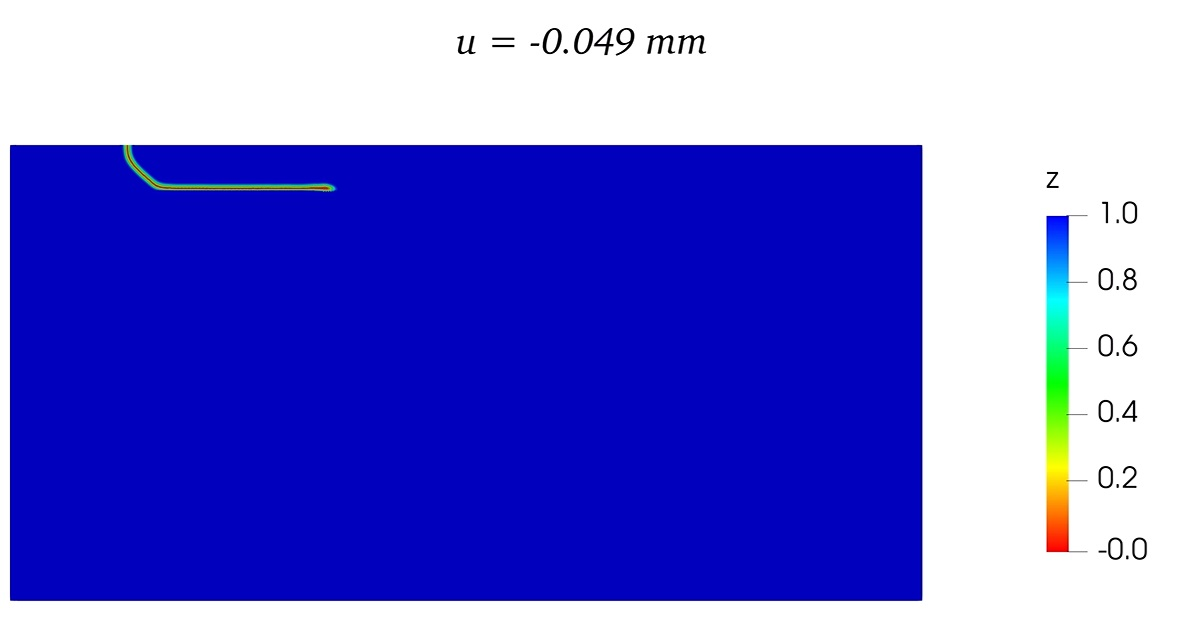